Following LDA Model Tutorial on GenSim
https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#sphx-glr-auto-examples-tutorials-run-lda-py

In [1]:
TED_TALK_TRANSCRIPTIONS_FILE_PATH = '../datasets/TEDLIUM_release-3/data/raw'

In [33]:
transcription_files = os.listdir(TED_TALK_TRANSCRIPTIONS_FILE_PATH)

filenames = []
transcriptions = []
for filename in transcription_files:
    filenames.append(filename)
    with open(f'{TED_TALK_TRANSCRIPTIONS_FILE_PATH}/{filename}', 'r') as fildes:
        curr_transcription = fildes.read()
        transcriptions.append(curr_transcription)

print('Num transcriptions:', len(transcriptions))

Num transcriptions: 2351


In [3]:
# Pre-processing and vectorizing
# Tokenizing documents
from nltk.tokenize import RegexpTokenizer

def pre_process_transcription(transcription):
    doc = transcription

    # Splitting documents into tokens
    tokenizer = RegexpTokenizer(r'\w+')
    doc = doc.lower()  # Convert to lowercase.
    doc = tokenizer.tokenize(doc)  # Split into words.

    # Remove numbers, but not words that contain numbers.
    doc = [token for token in doc if not token.isnumeric()]

    # Remove words that are only one character.
    doc = [token for token in doc if len(token) > 1]

    # Remove 'unk' token
    doc = [token for token in doc if token != 'unk']

    return doc

docs = transcriptions.copy()
docs = [pre_process_transcription(t) for t in docs]

In [4]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alprielse/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
def lemmitize_doc(doc):
    return [lemmatizer.lemmatize(token) for token in doc]
    
docs = [lemmitize_doc(d) for d in docs]

In [6]:
# Compute bi-grams
from gensim.models import Phrases

bigram = Phrases(docs, min_count=20)
def add_bigrams_to_doc(doc):
    for token in bigram[doc]:
        if '_' in token:
            # Token is a bigram, add to document.
            doc.append(token)

    return doc

docs = [add_bigrams_to_doc(d) for d in docs]


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [8]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.5)

In [152]:
corpus = [dictionary.doc2bow(doc) for doc in docs[:-10]] # Holding out last 10 for testing
testing_docs = docs[-10:]

In [11]:
print('Number of unique tokens: %d' % len(dictionary.items()))
print('Number of documents: %d' % len(corpus))
print('Number of testing documents', len(testing_docs))

Number of unique tokens: 16784
Number of documents: 2341
Number of testing documents 10


In [12]:
# Train LDA model.
from gensim.models import LdaModel

def train_lda_model(num_topics=10):
    # Set training parameters.
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.

    # Make a index to word dictionary.
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token

    model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every
    )

    top_topics = model.top_topics(corpus) #, num_words=20)

    # Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
    avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
    print(f'Average topic coherence: {avg_topic_coherence} for num_topics = {num_topics}')

    return model, num_topics, avg_topic_coherence

In [14]:
X = [50, 60, 70, 80, 90, 100, 110, 120, 130]
Y = [x[2] for x in map(train_lda_model, X)]

Average topic coherence: -1.951871074369289 for num_topics = 50
Average topic coherence: -2.1474078814569215 for num_topics = 60
Average topic coherence: -1.9640979037609856 for num_topics = 70
Average topic coherence: -1.9677986223416823 for num_topics = 80
Average topic coherence: -2.153282863223595 for num_topics = 90
Average topic coherence: -2.1038999718657667 for num_topics = 100
Average topic coherence: -2.1899806249391 for num_topics = 110
Average topic coherence: -2.3698997275081974 for num_topics = 120
Average topic coherence: -2.533822332414765 for num_topics = 130


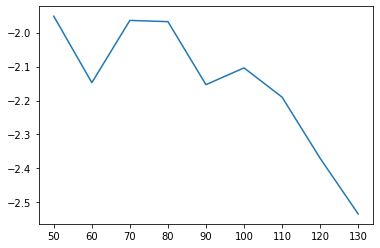

In [39]:
import matplotlib.pyplot as plt

plt.plot(X, Y)

In [17]:
model, _, avg_coherance = train_lda_model(130)

Average topic coherence: -2.4164330849511426 for num_topics = 130


In [40]:
import numpy as np
from sklearn.manifold import TSNE

def convert_topic_distribution_to_vec(gamma):
    vec = np.zeros((130))
    for topic, weight in gamma:
        vec[topic] = weight
    
    return vec

def dimensionality_reduction(vecs):
    embedded = TSNE(n_components=2).fit_transform(vecs)
    return embedded

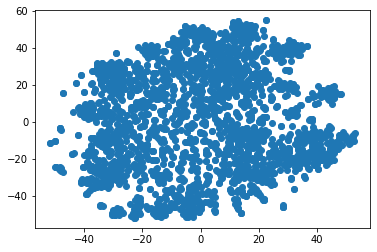

In [42]:
"""
Plots spatial distribution of all Ted Talks
"""

import matplotlib.pyplot as plt

corpus_gammas = [model.get_document_topics(d) for d in corpus]

corpus_vectors = [convert_topic_distribution_to_vec(g) for g in gammas]

dim_reducted_corpus_vectors = dimensionality_reduction(corpus_vectors)

plt.scatter(dim_reducted_corpus_vectors[:,0], dim_reducted_corpus_vectors[:,1])

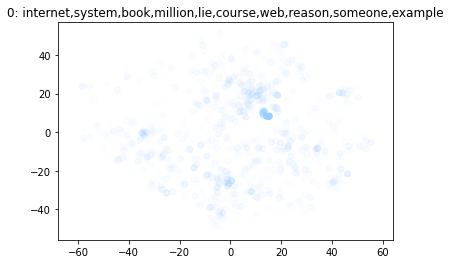

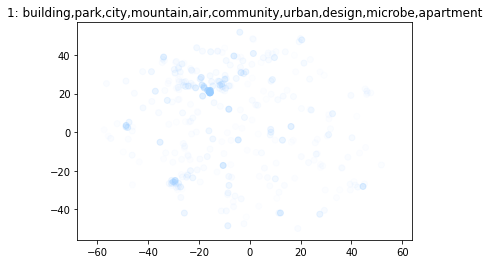

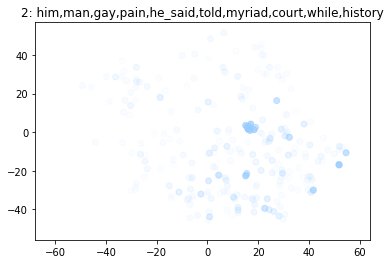

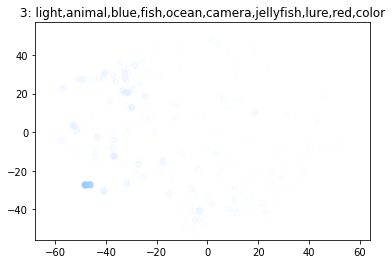

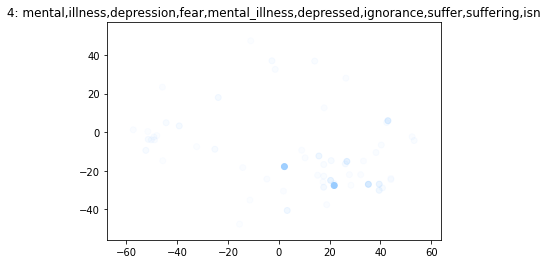

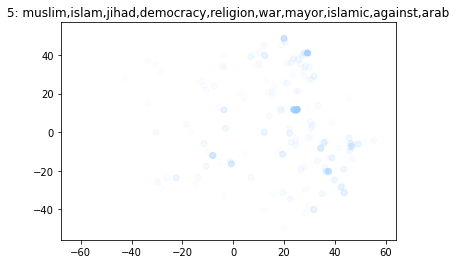

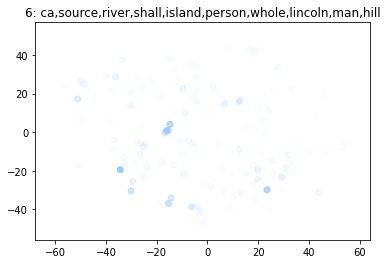

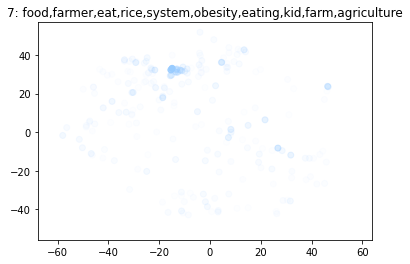

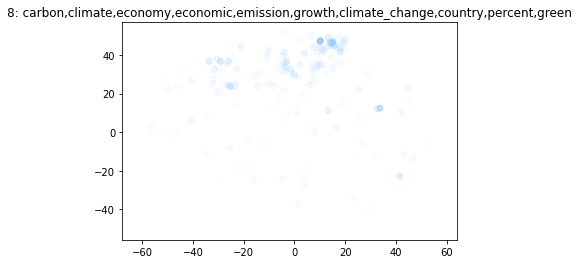

KeyboardInterrupt: 

In [46]:
def topic_words_list(topic_number):
    return [w for w, j in model.show_topic(topic_number)]

def format_topic_title(topic_number):
    return f'{topic_number}: ' + ','.join(topic_words_list(topic_number))

def plot_topic(topic_number, vecs, dim_reducted_vecs):
    n, d = vecs.shape

    # Get document's alpha intensity based off gamma[i][topic_number] value
    alphas = vecs[:,topic_number]
    alphas_min = alphas.min()
    alphas_max = alphas.max()
    alphas = (alphas - alphas_min) / (alphas_max - alphas_min) # normalize to 0-1 scale

    # RGB 153, 204, 255
    colors = np.zeros((n, 4))
    colors[:, 0] = np.full(shape=n, fill_value=153/255)
    colors[:, 1] = np.full(shape=n, fill_value=204/255)
    colors[:, 2] = np.full(shape=n, fill_value=255/255)
    colors[:, 3] = alphas # set alpha intensity

    topic_title = format_topic_title(topic_number)
    X = dim_reducted_vecs[:,0]
    Y = dim_reducted_vecs[:, 1]

    plt.scatter(X, Y, c=colors)
    plt.title(topic_title)
    plt.show()

# Plot each topic's spatial distribution for entire corpus
corpus_gammas = [model.get_document_topics(d) for d in corpus]

corpus_vectors = np.array([convert_topic_distribution_to_vec(g) for g in gammas])

dim_reducted_corpus_vectors = dimensionality_reduction(corpus_vectors)

"""
Uncomment below to produce spatial plots for all topics
"""
# for i in range(100):
#     plot_topic(i, corpus_vectors, dim_reducted_corpus_vectors)

In [160]:
"""
Exploring incremental bagging technique

testing_docs are concatenated together to simulate a livestreamed TED event. We then set the size of each increment `INCREMENT_LENGTH` which is the number of tokens to wait for before adding to the BOW representation of the doc and re-inferring the topic distribution.
"""

# testing_docs defined above

INCREMENT_LENGTH = 500
testing_docs = testing_docs[-3:] # temporary, testing with fewer documents

# Testing docs is defined as the last 10 Ted Talks in the dataset, these are their filenames
print('--- Test Documents ---')
for filename in filenames[-3:]: #temporary, testing with fewer documents
    print(filename)

# Concatenate all testing documents to simulate single transcription
document_livestream = []
document_lengths_aggregated = []
for i, doc in enumerate(testing_docs):
    if i == 0:
        document_lengths_aggregated.append(len(doc))
    else:
        document_lengths_aggregated += [document_lengths_aggregated[i - 1] + len(doc)]

    document_livestream += doc

incremental_transcriptions = []
increment_segments_assignments = []

# Create each incremental transcription (simulating livestream)
increment = 0

while increment * INCREMENT_LENGTH < len(document_livestream):
    last_token_idx = increment*INCREMENT_LENGTH

    curr_transcription = document_livestream[0:last_token_idx]

    # Figure out which document this segment belongs to (assignment)
    assignment = -1
    for i, length in list(enumerate(document_lengths_aggregated))[::-1]:
        if last_token_idx < length:
            assignment = i

        if last_token_idx > length:
            break
            

    incremental_transcriptions.append(curr_transcription)
    increment_segments_assignments.append(assignment)
  
    increment += 1

# Loop does not include last segment
incremental_transcriptions.append(document_livestream)

--- Test Documents ---
LucyMcRae_2012.txt
JohannaBlakley_2010W.txt
MurrayGellMannLANGUAGE_2007.txt


#FF9999
#FF9999
#FFCC99
#FFCC99
#FFFF99


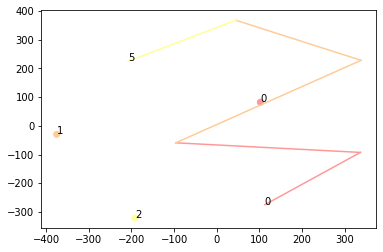

In [161]:
def document_to_gamma_vec(document):
    """
    Convert a raw document into sparse gamma vector
    """
    bow_representation = dictionary.doc2bow(document)

    gamma = model.get_document_topics(bow_representation)

    gamma_vec = convert_topic_distribution_to_vec(gamma)

    return gamma_vec

def dimensionality_reduction_docs_and_approx_docs(doc_vecs, approx_vecs):
    """
    Takes both the original and approx topic distribution vectors and projects these vectors in the same 2d space.

    @params
    - doc_vecs: the original documents' sparse topic distribution gamma vector
    - approx_vecs: the sparse gamma vectors of the topic distribution approximations 
    """
    combined_vecs = approx_vecs + doc_vecs
    num_doc_vecs = len(doc_vecs)

    combined_dim_reducted_vecs = dimensionality_reduction(combined_vecs)

    dr_approx_vecs = combined_dim_reducted_vecs[0:-num_doc_vecs]
    dr_doc_vecs = combined_dim_reducted_vecs[-num_doc_vecs:]

    return dr_approx_vecs, dr_doc_vecs

colors = [
     '#FF9999',
     '#FFCC99',
     '#FFFF99',
     '#CCFF99',
     '#99FF99',
     '#99FFCC',
     '#99FFFF',
     '#99CCFF',
     '#9999FF',
     '#CC99FF'
]   
    
# Calculate incremental vecs
incremental_vecs = [document_to_gamma_vec(d) for d in incremental_transcriptions]

# Calculate testing docs vecs
testing_docs_vecs = [document_to_gamma_vec(d) for d in testing_docs]

# Dim reduction
dim_reducted_incremental_vectors, dim_reducted_testing_docs_vecs = dimensionality_reduction_docs_and_approx_docs(testing_docs_vecs, incremental_vecs)

# Plot incremental topic distribution as trajectory
xy = dim_reducted_incremental_vectors
i = 0
for start, stop in zip(xy[:-1], xy[1:]):
    x, y = zip(start, stop)
    talk_assignment = increment_segments_assignments[i]
    color = colors[talk_assignment]
    print(color)
    plt.plot(x, y, color=color)
    i += 1

# Annotate trajectory with "segment numbers"
num_approximations = len(dim_reducted_incremental_vectors)
for i in range(0, num_approximations, 5):
    xy = dim_reducted_incremental_vectors[i]
    plt.annotate(i, xy)

# Plot original documents
X_original_docs, Y_original_docs = dim_reducted_testing_docs_vecs[:,0], dim_reducted_testing_docs_vecs[:,1]
plt.scatter(X_original_docs, Y_original_docs, c=colors[:3]) # temporary, testing with fewer documents

# Annotate original documents
for i in range(len(dim_reducted_testing_docs_vecs)):
    xy = dim_reducted_testing_docs_vecs[i]
    plt.annotate(i, xy)